In [144]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [145]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

df_meta=pd.read_csv('../../KOI_Data/kepler_dataset.csv')
kplr_ids=np.asarray(df['Kepler ID'].values)[[index_fp]]

In [146]:
#### importante:
def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmin(fluxs))

def extract_nans(fluxs):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = []
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = []
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 
    lc_wind_nan = np.asarray(lc_wind_nan)   
    lengths = np.asarray(lengths)   

    print("Cantidad de tramos: ",len(lengths))
    print("Largo promedio de tramos: ", np.mean(lengths))
    print("Mediana de largo de tramos: ", np.median(lengths))
    print("Min de largo de tramos: ", np.min(lengths))
    print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

### Version normal

In [147]:
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return  np.concatenate([estados_up,estados_low])

def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    transition_m += 1 #priors
    transition_m = transition_m/transition_m.sum(axis=-1, keepdims=True)        
    return transition_m
                    

## Version paralela (Numba)
para instalar numba: **pip install numba**

In [148]:
from numba import njit, jit
#from numba.typed import List

In [149]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

########### no lo logre hacer funcionar
#@njit(parallel=True, cache=False, fastmath=True)
def extract_nans(fluxs, plot=True):
    ###extrae los nans y deja tramos de valores continuos
    lc_wind_nan = []
    lengths = []

    sublist = [] #para que sepa que el tipo es float
    for value in fluxs:
        if np.isnan(value) and len(sublist) != 0:
            if len(sublist) != 1: ##borrar tramos de largo 1??
                lc_wind_nan.append(np.asarray(sublist))
                lengths.append(len(sublist))
            sublist = [] #para que sepa que el tipo es float
        elif np.isnan(value) and len(sublist) == 0:
            continue
        else: #if value not nan
            sublist.append(value) 

    if plot:
        lengths = np.asarray(lengths)   
        print("Cantidad de tramos: ",len(lengths))
        print("Largo promedio de tramos: ", np.mean(lengths))
        print("Mediana de largo de tramos: ", np.median(lengths))
        print("Min de largo de tramos: ", np.min(lengths))
        print("Max de largo de tramos: ", np.max(lengths))
    return lc_wind_nan

@njit(parallel=True, cache=False, fastmath=True)
def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

@njit(parallel=False, cache=True, fastmath=True)
def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    return 0 #if sale por arriba (mayor a 1)

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(fluxs, transition_m, states):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        transition_m[init_s, fin_s] += 1
    return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
    if n_sta_low == 0: 
        n_sta_low = n_sta_up 
    n_sta = n_sta_up+n_sta_low
    
    transition_m = np.zeros((n_sta,n_sta))
    
    states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low) 
    for fluxs in wind_fluxs:
        add_transitions(fluxs, transition_m, states)
    
    for i in range(n_sta):
        suma_i = 0
        for j in range(n_sta):
            transition_m[i,j] +=1 #priors
            suma_i += transition_m[i,j]
        transition_m[i] = transition_m[i]/suma_i #normalize
    return transition_m


In [150]:
det_state_2ways(1,-1, n_sta_up=5, n_sta_low=15) #20 estados en total

[(1.0, 0.8),
 (0.8, 0.6),
 (0.6, 0.39999999999999997),
 (0.39999999999999997, 0.19999999999999996),
 (0.19999999999999996, -5.551115123125783e-17),
 (-0.0, -0.06666666666666667),
 (-0.06666666666666667, -0.13333333333333333),
 (-0.13333333333333333, -0.2),
 (-0.2, -0.26666666666666666),
 (-0.26666666666666666, -0.3333333333333333),
 (-0.3333333333333333, -0.4),
 (-0.4, -0.4666666666666667),
 (-0.4666666666666667, -0.5333333333333333),
 (-0.5333333333333333, -0.6),
 (-0.6, -0.6666666666666666),
 (-0.6666666666666666, -0.7333333333333333),
 (-0.7333333333333333, -0.8),
 (-0.8, -0.8666666666666667),
 (-0.8666666666666667, -0.9333333333333333),
 (-0.9333333333333333, -1.0)]

In [152]:
%%time
fluxs = our_process[1]
fluxs = prepare_lc(fluxs) #divide by min
lc_tramos =  extract_nans(fluxs) #extract nans
#lc_tramos #lista de tramos...
#plt.show(lc_tramos[0])

Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146
CPU times: user 266 ms, sys: 4.83 ms, total: 271 ms
Wall time: 268 ms


### Comportamiento Falsos postiviso

In [115]:
falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

(3976, 71427)

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


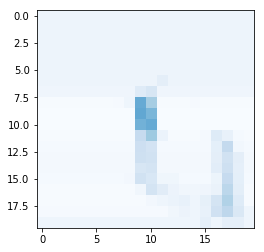

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


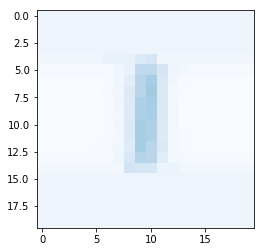

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


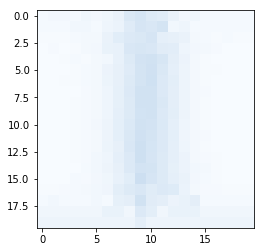

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


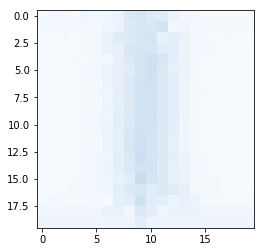

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


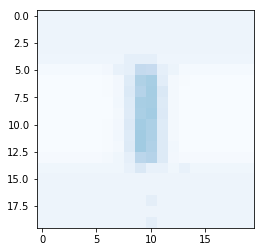

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


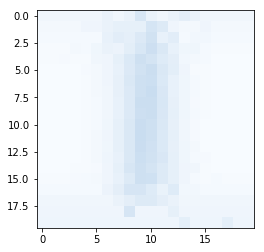

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


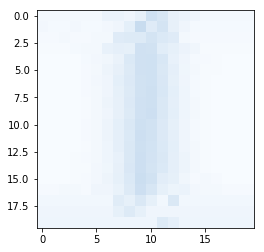

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


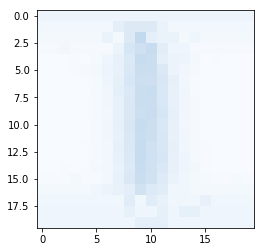

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


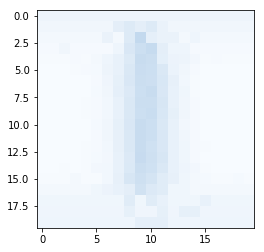

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


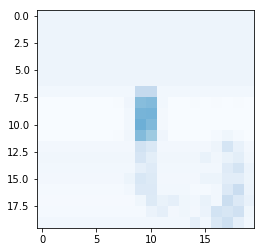

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


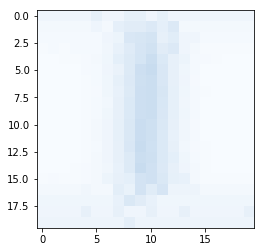

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


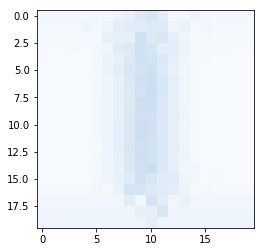

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


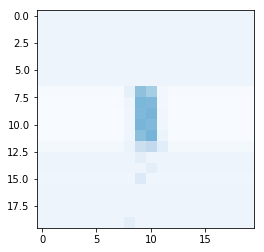

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


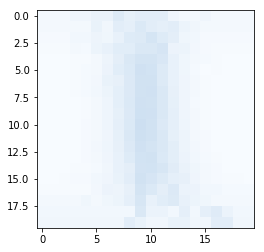

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


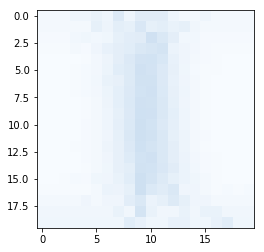

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


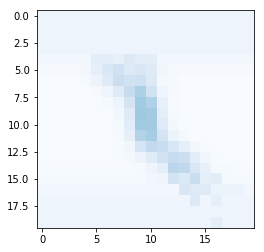

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


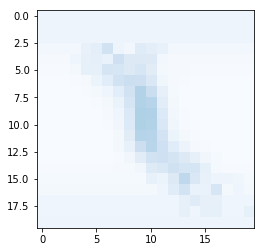

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


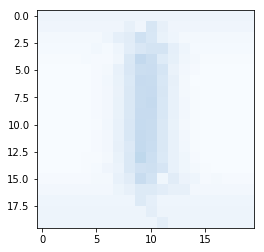

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


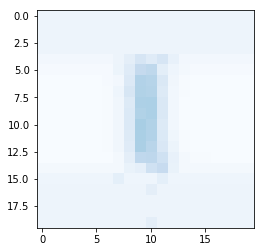

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


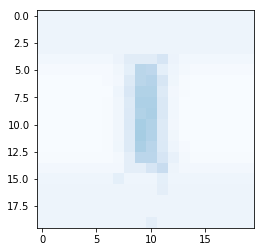

CPU times: user 1min 31s, sys: 6.54 s, total: 1min 38s
Wall time: 9.33 s


In [155]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=10, n_sta_low=10) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    plt.imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    plt.show()

### Comportamiento Confirmados

In [117]:
confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149


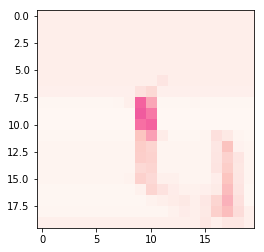

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


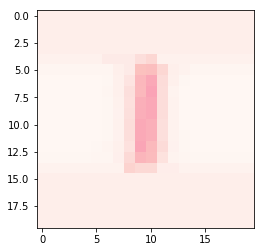

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


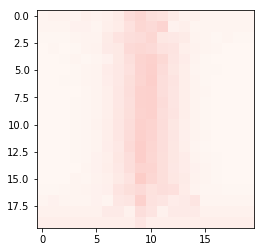

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


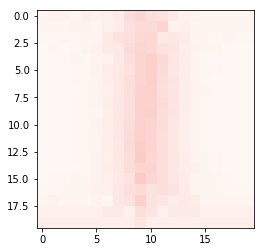

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


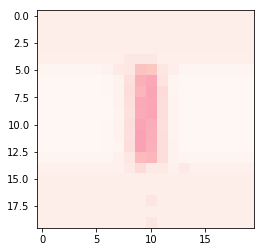

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146


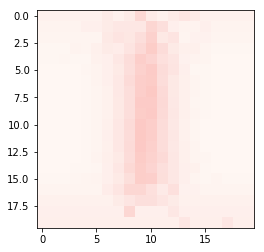

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


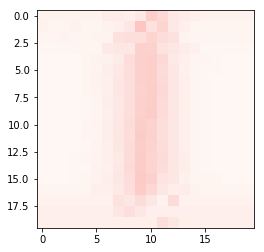

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


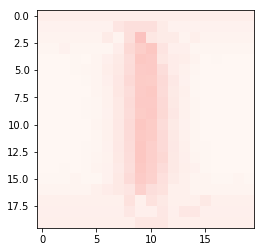

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149


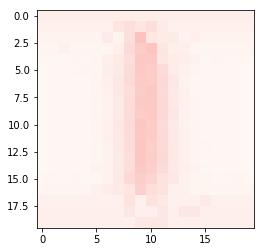

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


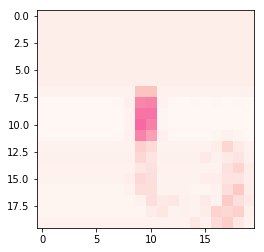

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


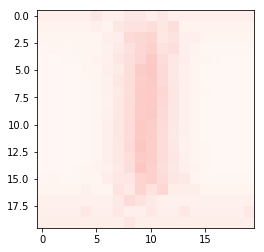

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


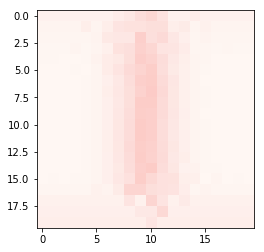

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


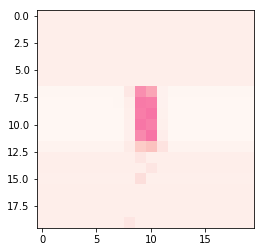

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


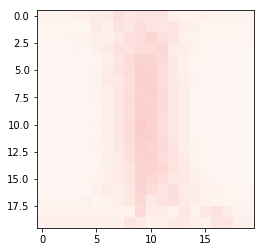

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


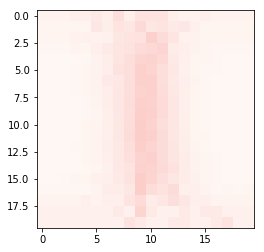

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


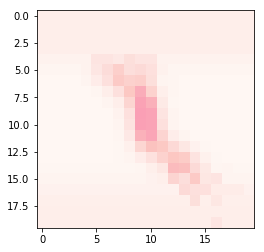

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


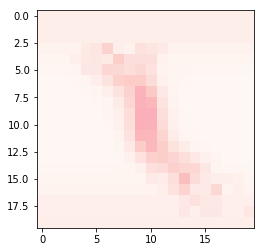

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149


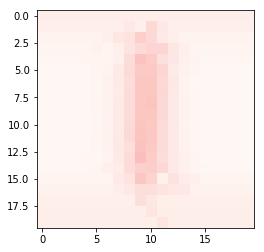

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


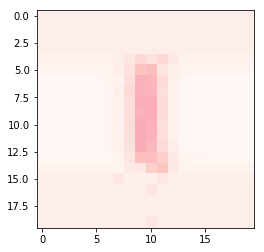

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


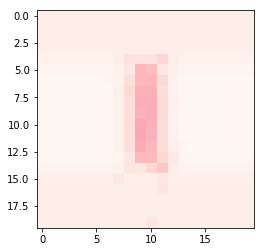

CPU times: user 1min 29s, sys: 6.43 s, total: 1min 35s
Wall time: 6.94 s


In [118]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=10, n_sta_low=10) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    plt.imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    plt.show()

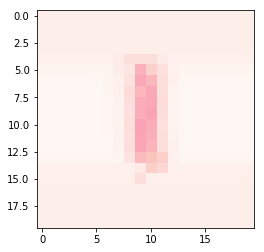

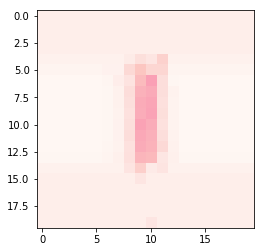

(20, 20)


In [163]:
number = 20

MTF_u10_d10_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d10.npy')  
MTF_u10_d10_noinv = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d10.npy')  
plt.imshow(MTF_u10_d10_noinv[number], cmap='RdPu', vmin=0, vmax=1) 
plt.show()
plt.imshow(MTF_u10_d10_inv[number], cmap='RdPu', vmin=0, vmax=1)
plt.show()

print(MTF_u10_d10_inv[number].shape)

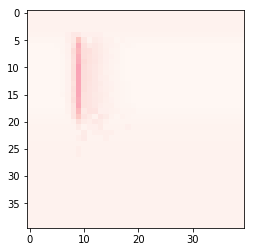

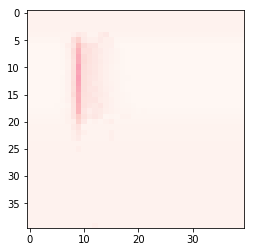

(40, 40)


In [165]:
number = 20

MTF_u10_d10_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d30.npy')  
MTF_u10_d10_noinv = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d30.npy')  
plt.imshow(MTF_u10_d10_noinv[number], cmap='RdPu', vmin=0, vmax=1) 
plt.show()
plt.imshow(MTF_u10_d10_inv[number], cmap='RdPu', vmin=0, vmax=1)
plt.show()

print(MTF_u10_d10_inv[number].shape)

In [120]:
img_nor = MTF_u10_d10_noinv[2]
img_inv = MTF_u10_d10_inv[2]

In [121]:
MTF_u10_d10_inv.shape

(8054, 20, 20)

In [122]:
df_aux = pd.read_csv("../../KOI_Data/kepler_dataset.csv")
labels = (df_aux["NExScI Disposition"] == "CONFIRMED").values*1
df_aux

,Kepler ID,KOI Name,Kepler Name,KOI Number,Kepler Disposition,NExScI Disposition,RA (J2000),RA Error,Dec (J2000),Dec Error,...,Contamination Flag,Insolation Flux,Insolation Flux err1,Insolation Flux err2,Fitted Stellar Density,Fitted Stellar Density err1,Fitted Stellar Density err2,Planetary Fit,Disposition Score,File Name
0,757450,K00889.01,Kepler-75 b,889.01,CANDIDATE,CONFIRMED,19 24 33.024,0.0,+36 34 38.57,0.0,...,0,83.21,16.69,-13.87,11.62061,0.20683,-0.40258,LS+MCMC,0.999,kplr000757450-20160128150956_dvt.fits
1,892772,K01009.01,NaN,1009.01,FALSE POSITIVE,FALSE POSITIVE,19 24 36.811,0.0,+36 40 43.83,0.0,...,0,119.70,48.69,-36.91,0.88510,0.10080,-0.39457,LS+MCMC,0.000,kplr000892772-20160128150956_dvt.fits
2,1025986,K07621.01,NaN,7621.01,FALSE POSITIVE,FALSE POSITIVE,19 24 08.086,0.0,+36 46 15.75,0.0,...,0,2.00,0.92,-0.76,33.55994,16.58298,-31.53180,LS+MCMC,0.000,kplr001025986-20160128150956_dvt.fits
3,1026032,K06252.01,NaN,6252.01,FALSE POSITIVE,FALSE POSITIVE,19 24 10.577,0.0,+36 43 45.38,0.0,...,0,98.60,52.46,-21.18,0.73874,0.00021,-0.00735,LS+MCMC,0.000,kplr001026032-20160128150956_dvt.fits
4,1026957,K00958.01,NaN,958.01,CANDIDATE,CANDIDATE,19 25 01.078,0.0,+36 44 37.00,0.0,...,0,13.18,3.00,-1.98,102.86534,5.47239,-30.25813,LS+MCMC,1.000,kplr001026957-20160128150956_dvt.fits
5,1161345,K00984.01,NaN,984.01,CANDIDATE,CANDIDATE,19 24 11.712,0.0,+36 50 23.58,0.0,...,0,186.31,56.73,-28.39,8.16471,4.69586,-1.63188,LS+MCMC,0.711,kplr001161345-20160128150956_dvt.fits
6,1293031,K04162.01,NaN,4162.01,FALSE POSITIVE,FALSE POSITIVE,19 24 05.033,0.0,+36 54 13.13,0.0,...,0,149399.93,35721.31,-106451.43,0.06737,0.00658,-0.00461,LS+MCMC,0.000,kplr001293031-20160128150956_dvt.fits
7,1293046,K07622.01,NaN,7622.01,FALSE POSITIVE,FALSE POSITIVE,19 24 06.372,0.0,+36 54 58.93,0.0,...,0,3.44,0.94,-0.97,34.69388,13.11193,-21.13275,LS+MCMC,0.000,kplr001293046-20160128150956_dvt.fits
8,1431122,K00994.01,NaN,994.01,CANDIDATE,CANDIDATE,19 24 34.198,0.0,+37 03 40.76,0.0,...,0,283.62,100.01,-78.24,0.05666,3.20152,-0.06620,LS+MCMC,0.990,kplr001431122-20160128150956_dvt.fits
9,1432214,K00998.01,NaN,998.01,FALSE POSITIVE,FALSE POSITIVE,19 25 31.846,0.0,+37 04 22.76,0.0,...,0,4.68,2.07,-1.12,17.58377,0.76473,-0.48796,LS+MCMC,0.000,kplr001432214-20160128150956_dvt.fits


In [123]:
labels

array([1, 0, 0, ..., 0, 0, 0])

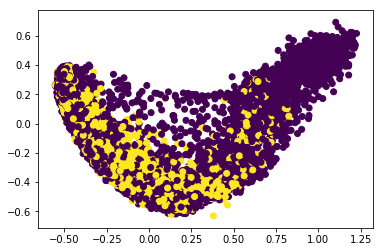

In [124]:
from sklearn.decomposition import PCA
model = PCA(2)
aux = model.fit_transform(MTF_u10_d10_noinv.reshape([MTF_u10_d10_noinv.shape[0],20*20]))

plt.scatter(aux[:,0],aux[:,1], c=labels)

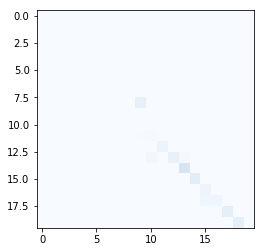

In [125]:
plt.imshow(img_nor-img_inv, cmap='Blues', vmin=0, vmax=1)
#si existen cambios en los pixeles

In [191]:
img_inv.shape

(20, 20)

In [192]:
rgb = np.dstack((img_nor,img_inv))
rgb.shape

(20, 20, 2)

In [129]:
import math
from skimage import io
from skimage import transform
from scipy import fftpack

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal,misc

def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
    kernel_2D *= 1.0 / kernel_2D.max()
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='jet')
        plt.title("Image")
        plt.show()
    return kernel_2D

#gaussian_kernel(10,sigma = 25,verbose = True)


def gaussian_2fors(size, sigma_x,sigma_y,frequency):
    size = size//frequency + 1
    fil = np.zeros((int(size), int(size)))
    for x_ind,x in enumerate(np.arange(0,size)):
        for y_ind,y in enumerate(np.arange(0,size)):
            fil[x_ind][y_ind] = np.exp(-(((x-size//2)**2)/(2*(sigma_x**2))+((y-size//2)**2)/(2*(sigma_y**2))))
    normalized_fil = fil/np.sum(fil)
    fig, ax = plt.subplots(figsize=(4,4))
    ax.imshow(normalized_fil, extent=[-size//2,size//2,-size//2,size//2],cmap = 'gray')
    return normalized_fil

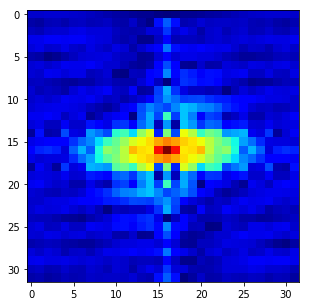

In [130]:
from scipy import fftpack
freq_img=fftpack.fft2(MTF_u10_d10_noinv,(32,32))
#freq_img = np.abs(freq_img)

plt.figure(figsize=(5,5))
plt.imshow(fftpack.fftshift(np.log(1+np.abs(freq_img[20]))),cmap="jet")

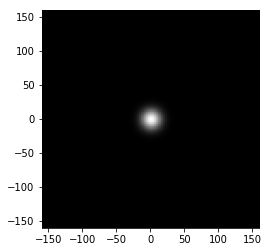

In [131]:
SZ = 32
gauss_fill = gaussian_2fors(SZ,10.0,10.0,0.1)

In [132]:
frequency_gauss_fill = fftpack.fft2(gauss_fill, (32, 32))
frequency_img_conv =  freq_img[20]*frequency_gauss_fill

reverse_frequency_img_conv = fftpack.ifft2(frequency_img_conv)

hs=int(np.floor((SZ/0.5)/2.))
reverse_frequency_img_conv = np.real(reverse_frequency_img_conv)

img_crop = reverse_frequency_img_conv[0:19, 0:19]

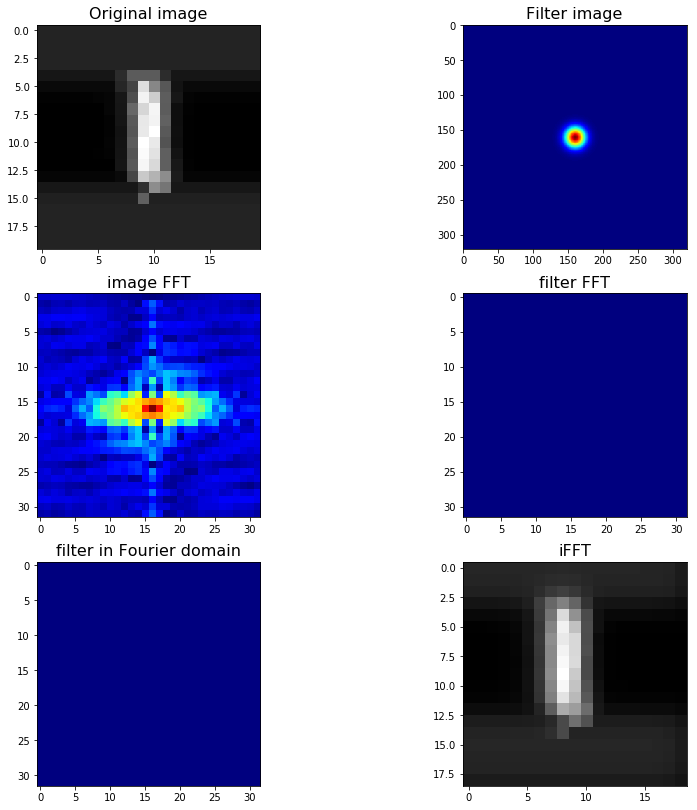

In [133]:
#Check the process
plt.subplot(3,2,1)
plt.imshow(MTF_u10_d10_noinv[20],cmap="gray")
plt.title('Original image', size=16)

plt.subplot(3,2,2)
plt.imshow(gauss_fill,cmap="jet")
plt.title('Filter image', size=16)

plt.subplot(3,2,3)
plt.imshow(fftpack.fftshift(np.log(1+np.abs(freq_img[20]))),cmap="jet")
plt.title('image FFT', size=16)

plt.subplot(3,2,4)
plt.imshow(fftpack.fftshift(np.log(1+np.abs(frequency_gauss_fill))),cmap="jet")
plt.title('filter FFT', size=16)

plt.subplot(3,2,5)
plt.imshow(fftpack.fftshift(np.log(1+np.abs(frequency_img_conv))),cmap="jet")
plt.title('filter in Fourier domain', size=16)

plt.subplot(3,2,6)
plt.imshow(img_crop,cmap="gray")
plt.title('iFFT', size=16)
plt.gcf().set_size_inches((14,14))

In [134]:
MTF_u10_d10_noinv.shape

(8054, 20, 20)

In [135]:
tt =  freq_img*frequency_gauss_fill
tt2 = fftpack.ifft2(tt)
hs=int(np.floor((SZ/0.5)/2.))
tt3 = np.real(tt2)
final_final = []
for i in tt3:
    img_crop = i[hs:20+hs, hs:20+hs]
    final_final.append(img_crop)
final_final = np.asarray(final_final)

In [136]:
final_final.shape

(8054, 0, 0)

In [137]:
#from sklearn.decomposition import PCA
#model = PCA(2)
#aux = model.fit_transform(freq_img.reshape([freq_img.shape[0],64*64]))

#plt.scatter(aux[:,0],aux[:,1], c=labels)

In [138]:
#from sklearn.decomposition import PCA
#model = PCA(2)
#aux = model.fit_transform(final_final.reshape([final_final.shape[0],20*20]))

#plt.scatter(aux[:,0],aux[:,1], c=labels)

# 3er channel

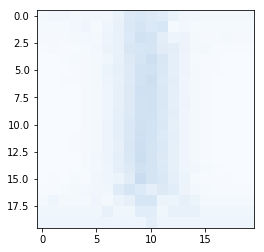

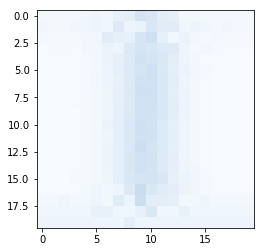

(20, 20)


In [139]:
number = 23

MTF_u10_d10_inv = np.load('/work/work_teamEXOPLANET/MTF_margarita/invertidos/MTF_u10_d10.npy')  
MTF_u10_d10_noinv = np.load('/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/MTF_u10_d10.npy')  
plt.imshow(MTF_u10_d10_noinv[number], cmap='Blues', vmin=0, vmax=1) 
plt.show()
plt.imshow(MTF_u10_d10_inv[number], cmap='Blues', vmin=0, vmax=1)
plt.show()

print(MTF_u10_d10_inv[number].shape)

In [161]:
falsos_pos=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

for i in 
fluxs = prepare_lc(lc_our_detrend) 
lc_tramos =  extract_nans(fluxs)

NameError: name 'lc_our_detrend' is not defined

In [141]:
plt.show(lc_tramos[number])

Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
def get_time_channel(image):
    